In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator  # pylint: disable=import-error, no-name-in-module
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
from qiskit.visualization import array_to_latex
import numpy as np
from qiskit import assemble
from math import pi
from qiskit.visualization import plot_bloch_multivector, plot_histogram, array_to_latex
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools and circuits
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import matplotlib.pyplot as plt
import numpy as np
import math

## Quantum Phase Estimation (QPE)

In [8]:
# We initialize  |𝜓⟩=|1⟩ by applying an  𝑋 gate:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw()

q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
c: 3/═════

In [9]:
# Next, we apply Hadamard gates to the counting qubits:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ X ├
     └───┘
c: 3/═════

In [10]:
# We'll use Qiskit's PhaseGate to create the  𝑇 operation. The phase gate does the transformation
# 𝑃|1⟩=𝑒𝑖𝜆|1⟩ , where  𝜆 is the angle we provide. Since we want to implement  𝑇 , which performs 
# 𝑇|1⟩=𝑒2𝜋𝑖𝜃|1⟩ , we need to set  𝜆=2𝜋8=𝜋/4 .

repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(math.pi/4, counting_qubit, 3); # controlled-T
    repetitions *= 2
qpe.draw()

┌───┐                                                               
q_0: ┤ H ├─■─────────────────────────────────────────────────────────────
     ├───┤ │                                                             
q_1: ┤ H ├─┼────────■────────■───────────────────────────────────────────
     ├───┤ │        │        │                                           
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■───────
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4) 
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■───────
     └───┘                                                               
c: 3/════════════════════════════════════════════════════════════════════

In [11]:
# We apply the inverse quantum Fourier transformation 
# to convert the state of the counting register, then measure the counting register:
qpe.barrier()
# Apply inverse QFT
qpe = qpe.compose(QFT(3, inverse=True), [0,1,2])
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

qpe.draw()

┌───┐                                                                ░ »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────░─»
     ├───┤ │                                                              ░ »
q_1: ┤ H ├─┼────────■────────■────────────────────────────────────────────░─»
     ├───┤ │        │        │                                            ░ »
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■────────░─»
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  ░ »
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■────────░─»
     └───┘                                                                ░ »
c: 3/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌──────────┐ ░ ┌─┐      
«q_0: ┤0         ├─░─┤M├──────
«     │          │ ░ └╥┘┌─┐   
«q_1: ┤1 IQFT_dg ├─░──╫─┤M├───
«     │          │ ░  ║ └╥┘┌─┐
«q_2: ┤2         ├─░──╫──╫─┤M├
«     └──────────┘ ░  ║  ║ └╥┘
«q_3: ─────────────░──╫──╫──╫─
«                  ░  ║  ║  ║ 
«c: 3/════════════════╩══╩══╩═
«                     0  1  2

## Simulation

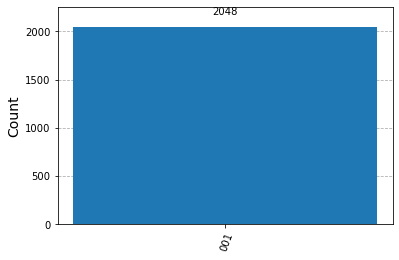

In [12]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
results = aer_sim.run(t_qpe, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We see we get one result (`001`) with certainty, which translates to the decimal: `1`. We now need to divide our result (`1`) by $2^n$ to get $\theta$:



$$ \theta = \frac{1}{2^3} = \frac{1}{8} $$



This is exactly the result we expected!

Instead of a $T$-gate, let’s use a gate with $\theta = \frac{1}{3}$.

In the cell below, we set up our circuit as we did with the last example.

We'll use Qiskit's [`PhaseGate`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PhaseGate.html) again, which does $P|1\rangle = e^{i\lambda}|1\rangle$. Since we want to implement $U|1\rangle = e^{2\pi i \tfrac{1}{3}}|1\rangle$, we need to set $\lambda = \tfrac{2 \pi}{3}$.

In [13]:
# Create and set up circuit
qpe2 = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qpe2 = qpe2.compose(QFT(3, inverse=True), [0,1,2])

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)

qpe2.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_3: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 3/═════════════════════════════════════════════════════════════════»
                                                                      »
«               ┌──────────┐┌─┐      
«q_0: ──────────┤0         ├┤M├──────
«               │          │└╥┘┌─┐   
«q_1: ──────────┤1 IQFT_dg ├─╫─┤M├───
«               │          │ ║ └╥┘┌─┐
«q_2: ─■────────┤2         ├─╫──╫─┤M├
«      │P(2π/3) └──────────┘ ║  ║ └╥┘
«q_3: ─■─────────────────────╫──╫──╫─
«                            ║  ║  ║ 
«c: 3/═══════════════════════╩══╩══╩═
«                            0  1  2

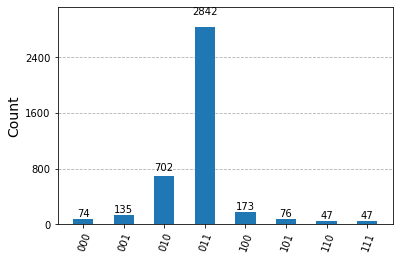

In [14]:
# Let's see the results!
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qpe2 = transpile(qpe2, aer_sim)
results = aer_sim.run(t_qpe2, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We are expecting the result $\theta = 0.3333\dots$, and we see our most likely results are `010(bin) = 2(dec)` and `011(bin) = 3(dec)`. These two results would tell us that $\theta = 0.25$ (off by 25%) and $\theta = 0.375$ (off by 13%) respectively. The true value of $\theta$ lies between the values we can get from our counting bits, and this gives us uncertainty and imprecision.

### 3.2 The Solution <a id='the_solution'></a>
To get more precision we simply add more counting qubits. We are going to add two more counting qubits:

In [15]:
# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(5)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cp(angle, counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qpe3 = qpe3.compose(QFT(5, inverse=True), range(5))

# Measure of course!
qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)

qpe3.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │         │         │         │         │         │        »
q_3: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │         │         │         │         │         │        »
q_4: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_5: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 5/═════════════════════════════════════════════════════════════════»
                                                                      »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ─■────────────────────────────────────────────────────────────────────»
«      │                                                                    »
«q_3: ─┼─────────■─────────■─────────■─────────■─────────■─────────■────────»
«      │         │         │         │         │         │         │        »
«q_4: ─┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_5: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_3: ─■─────────■──────────────────────────────────────────────────────────»
«      │         │                                                          »
«q_4: ─┼─────────┼─────────■─────────■─────────■─────────■─────────■────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_5: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_3: ─────────────────────────────────

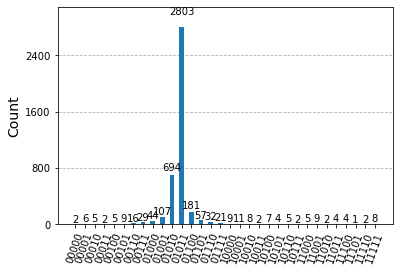

In [16]:
# Let's see the results!
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qpe3 = transpile(qpe3, aer_sim)
results = aer_sim.run(t_qpe3, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

The two most likely measurements are now `01011` (decimal 11) and `01010` (decimal 10). Measuring these results would tell us $\theta$ is:

$$
\theta = \frac{11}{2^5} = 0.344,\;\text{  or  }\;\; \theta = \frac{10}{2^5} = 0.313
$$

These two results differ from $\frac{1}{3}$ by 3% and 6% respectively. A much better precision!